<a href="https://colab.research.google.com/github/claudiaxpreda/SII/blob/main/SII_Assignment_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import gensim 
from gensim.models import Word2Vec
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Embedding, Dropout, Activation, Input, SpatialDropout1D, concatenate
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D, AveragePooling1D, Conv1D, GlobalAveragePooling1D, GlobalMaxPooling1D
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing import text, sequence


In [2]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download("punkt")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
# !wget http://nlp.stanford.edu/data/glove.6B.zip
# !unzip glove*.zip

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
WORKDIR = os.getcwd()
FILES_PATH = WORKDIR + '/drive/MyDrive/SII/SII-Challenge/'


In [4]:
DEV_NAME = 'referate-dev.json'
TRAIN_NAME = 'referate-train.json'
TEST_DEV = 'referate-test.json'

def get_frame(name):
  return pd.read_json(FILES_PATH + name)


In [5]:
train = get_frame(TRAIN_NAME)
dev = get_frame(DEV_NAME)
test = get_frame(TEST_DEV)

def print_size(name, frame):
  format = 'The size of {} set is: {}'
  print(format.format(name, len(frame)))

**Data Analyze**

In [8]:
print_size('train', train)
print_size('dev', dev)
print_size('test', test)

The size of train set is: 4725
The size of dev set is: 500
The size of test set is: 500


In [ ]:
train.info()

In [6]:
stopwords = []

with open('/content/drive/MyDrive/SII/SII-Challenge/romanian_stopwords.txt', 'r') as f: 
    for line in f:
        stopwords.append(line.strip())

print(stopwords)

['vreo', 'acelea', 'cata', 'cita', 'degraba', 'lor', 'alta', 'tot', 'ai', 'dat', 'despre', 'peste', 'bine', 'dar', 'foarte', 'avea', 'multi', 'cit', 'cat', 'alt', 'mai', 'sa', 'fie', 'tu', 'intrucat', 'multe', 'orice', 'dintr', 'dintre', 'dintr-o', 'dintr-un', 'se', 'intr', 'intr-o', 'intr-un', 'niste', 'multa', 'insa', 'il', 'fost', 'a', 'abia', 'nimic', 'sub', 'acel', 'in', 'altceva', 'si', 'avem', 'altfel', 'c', 'ea', 'acest', 'li', 'parca', 'fi', 'dintre', 'unele', 'm', 'acestei', 'mare', 'cel', 'este', 'pe', 'atitia', 'atatia', 'uneori', 'acela', 'iti', 'astazi', 'acestui', 'o', 'imi', 'ele', 'ceilalti', 'pai', 'fata', 'noua', 'sa-ti', 'altul', 'au', 'i', 'prin', 'conform', 'aceste', 'anume', 'azi', 'k', 'unul', 'ala', 'unei', 'fara', 'ei', 'la', 'aceeasi', 'u', 'inapoi', 'acestea', 'acesta', 'aceasta', 'catre', 'sale', 'asupra', 'as', 'aceea', 'ba', 'ale', 'da', 'le', 'apoi', 'aia', 'suntem', 'cum', 'isi', 'inainte', 's', 'de', 'cind', 'cand', 'cumva', 'chiar', 'acestia', 'daca',

In [ ]:
train.isnull().sum()

In [ ]:
train.head(5)

In [ ]:
train_categories = train.category.unique()
test_categories = test.category.unique()

print(train_categories)

In [ ]:
no_text = train[train['text'].str.len() == 0]
no_text

**Embeddings**

In [7]:
train['processed_text'] = train['text'].apply(lambda x: x.lower())
train.head(5)

,index,filename,text,category,grade,processed_text
0,3685,Referat Piercing-ul si adolescentii,Piercing-ul si tatuajele - vanitati adolescent...,psihologie,5.65,piercing-ul si tatuajele - vanitati adolescent...
1,775,Gradinile Suspendate Ale Semiramidei,GRADINILE SUSPENDATE ALE SEMIRAMIDEI A doua mi...,istorie,9.00,gradinile suspendate ale semiramidei a doua mi...
2,1765,Referat Mihail Sadoveanu,MIHAIL SADOVEANU (1880-1961) \nMihail Sadovea...,romana,5.36,mihail sadoveanu (1880-1961) \nmihail sadovea...
3,3691,Referat Eminescu,EMINESCU \nS-a nascut pe 15 ianuarie 1850 la ...,romana,5.35,eminescu \ns-a nascut pe 15 ianuarie 1850 la ...
4,3402,Moara,Moara cu noroc Ioan Slavici \nCaracterizarea l...,romana,10.00,moara cu noroc ioan slavici \ncaracterizarea l...


In [8]:
def remove_stopwords(text):
  return ' '.join([word for word in text.split() if word not in stopwords])

train['processed_text'] = train['processed_text'].apply(lambda x: remove_stopwords(x))

train.head(5)

,index,filename,text,category,grade,processed_text
0,3685,Referat Piercing-ul si adolescentii,Piercing-ul si tatuajele - vanitati adolescent...,psihologie,5.65,piercing-ul tatuajele - vanitati adolescentine...
1,775,Gradinile Suspendate Ale Semiramidei,GRADINILE SUSPENDATE ALE SEMIRAMIDEI A doua mi...,istorie,9.00,gradinile suspendate semiramidei doua minune l...
2,1765,Referat Mihail Sadoveanu,MIHAIL SADOVEANU (1880-1961) \nMihail Sadovea...,romana,5.36,mihail sadoveanu (1880-1961) mihail sadoveanu ...
3,3691,Referat Eminescu,EMINESCU \nS-a nascut pe 15 ianuarie 1850 la ...,romana,5.35,eminescu s-a nascut 15 ianuarie 1850 botosani ...
4,3402,Moara,Moara cu noroc Ioan Slavici \nCaracterizarea l...,romana,10.00,moara ioan slavici caracterizarea ghita ghita ...


In [9]:
train.processed_text.iloc[2]

'mihail sadoveanu (1880-1961) mihail sadoveanu s-a nascut 5 noiembrie 1880, pascani, avocatului alexandru sadoveanu profirei ursache, razesi. urmeaza gimnaziul "alecu donici" falticeni. studia gimnaziu, 1896, intentioneaza alcatui, impreuna coleg, monografie stefan mare, renuntind, insa, lipsa izvoare. urmeaza cursurile liceului national iasi. debuteaza revista bucuresteana dracu 1897. 1898 incepe colaboreze viata gala galaction, n.d.cocea, tudor arghezi altii, semnind numele sau, pseudonimul m.s.cobuz. 1904 stabileste bucuresti,, casatoreste unsprezece copii. an loc debutul editorial volume deodata - povestiri, dureri inabusite, crisma mos precu, soimii - sadoveanu manifesta predilectie deosebita istorie. nicolae iorga numi anul 1904 "anul sadoveanu". 1910 numit functia director teatrului national iasi. an publica volumele povestiri seara (la editura minerva), genoveva brabant, brosura putem scapa nevoi putem dobindi pamint s.a. colaboreaza revista "samanatorul", simti apropiat spirit

In [9]:
import re

def clean_numbers(x):

    x = re.sub('[0-9]{5,}', '#####', x)
    x = re.sub('[0-9]{4}', '####', x)
    x = re.sub('[0-9]{3}', '###', x)
    x = re.sub('[0-9]{2}', '##', x)
    x = re.sub('[0-9]', '#', x)

    return x

train['processed_text'] = train['processed_text'].apply(lambda x : clean_numbers(x))
train.head(5)

,index,filename,text,category,grade,processed_text
0,3685,Referat Piercing-ul si adolescentii,Piercing-ul si tatuajele - vanitati adolescent...,psihologie,5.65,piercing-ul tatuajele - vanitati adolescentine...
1,775,Gradinile Suspendate Ale Semiramidei,GRADINILE SUSPENDATE ALE SEMIRAMIDEI A doua mi...,istorie,9.00,gradinile suspendate semiramidei doua minune l...
2,1765,Referat Mihail Sadoveanu,MIHAIL SADOVEANU (1880-1961) \nMihail Sadovea...,romana,5.36,mihail sadoveanu (####-####) mihail sadoveanu ...
3,3691,Referat Eminescu,EMINESCU \nS-a nascut pe 15 ianuarie 1850 la ...,romana,5.35,eminescu s-a nascut ## ianuarie #### botosani ...
4,3402,Moara,Moara cu noroc Ioan Slavici \nCaracterizarea l...,romana,10.00,moara ioan slavici caracterizarea ghita ghita ...


In [ ]:
# train['processed_text'] = train['processed_text'].apply(lambda x : re.sub(r'\s+$', '', x, flags=re.M))
# train.head(5)

,index,filename,text,category,grade,processed_text
0,3685,Referat Piercing-ul si adolescentii,Piercing-ul si tatuajele - vanitati adolescent...,psihologie,5.65,piercing-ul si tatuajele - vanitati adolescent...
1,775,Gradinile Suspendate Ale Semiramidei,GRADINILE SUSPENDATE ALE SEMIRAMIDEI A doua mi...,istorie,9.00,gradinile suspendate ale semiramidei a doua mi...
2,1765,Referat Mihail Sadoveanu,MIHAIL SADOVEANU (1880-1961) \nMihail Sadovea...,romana,5.36,mihail sadoveanu (####-####)\nmihail sadovean...
3,3691,Referat Eminescu,EMINESCU \nS-a nascut pe 15 ianuarie 1850 la ...,romana,5.35,eminescu\ns-a nascut pe ## ianuarie #### la b...
4,3402,Moara,Moara cu noroc Ioan Slavici \nCaracterizarea l...,romana,10.00,moara cu noroc ioan slavici\ncaracterizarea lu...


In [ ]:
# train['processed_text'] = train['processed_text'].apply(lambda x : x.rstrip('\r\n\t').replace('\n', ' ').replace('\t', ' '))
# train.head(5)

,index,filename,text,category,grade,processed_text
0,3685,Referat Piercing-ul si adolescentii,Piercing-ul si tatuajele - vanitati adolescent...,psihologie,5.65,piercing-ul si tatuajele - vanitati adolescent...
1,775,Gradinile Suspendate Ale Semiramidei,GRADINILE SUSPENDATE ALE SEMIRAMIDEI A doua mi...,istorie,9.00,gradinile suspendate ale semiramidei a doua mi...
2,1765,Referat Mihail Sadoveanu,MIHAIL SADOVEANU (1880-1961) \nMihail Sadovea...,romana,5.36,mihail sadoveanu (####-####) mihail sadoveanu...
3,3691,Referat Eminescu,EMINESCU \nS-a nascut pe 15 ianuarie 1850 la ...,romana,5.35,eminescu s-a nascut pe ## ianuarie #### la bo...
4,3402,Moara,Moara cu noroc Ioan Slavici \nCaracterizarea l...,romana,10.00,moara cu noroc ioan slavici caracterizarea lui...


In [14]:
train.processed_text.iloc[100]


'echipamentul baza echipamentul esential format coif (cassis), armura (lorica segmentata), sabie # taisuri (gladius), sulita lungime medie pt. aruncare (pilium), scutul (scutum) sandale. coiful fabricat general bronz incepand anul ### i.e.n. acoperea ceafa fruntea. armura numea lorica segmentata , fiind formata lame bronz suprapuse. purta aseamenea camasa zale. gladiusul sabie extrem eficienta. dimensiuni mici (aprox ##cm), fiind usor manuit grea, necesitand putina forta energie. piliumul (sulita) purta rol essential lupta. compunea varf ascutit metal asezat suport lemn. sulita, lunga #m, aruncata adversar putand zdrobeasca scutul acestuia, facandu-l vulnerabil mortii. apararea frontala soldatului roman oferita scutum. rotund, bronz, oval, dreptunghiular, lemn, tarziu urma semicilindric hexagonal. lupta, soldatii purtau mantie rosie timpul luptei. tinea caldura inducea frica ochii inamicului. soldat incaltaminte. timpuri, aveau sandale. aceastea erau rezistente usor reparat. artileria 

In [10]:
train['processed_text'] = train['processed_text'].apply(lambda x : re.sub(r'[^\x00-\x7F]+',' ', x))



In [12]:
dev['processed_text'] = dev['text'].apply(lambda x: x.lower())
dev['processed_text'] = dev['processed_text'].apply(lambda x : remove_stopwords(x))
dev['processed_text'] = dev['processed_text'].apply(lambda x : re.sub(r'[^\x00-\x7F]+',' ', x))
dev['processed_text'] = dev['processed_text'].apply(lambda x : clean_numbers(x))

# dev['processed_text'] = dev['processed_text'].apply(lambda x : re.sub(r'\s+$', '', x, flags=re.M))
# dev['processed_text'] = dev['processed_text'].apply(lambda x : x.rstrip('\r\n').replace('\n', ' ').replace('\t', ' '))
# dev.head(10)
# dev.text.iloc[3]
dev.processed_text.iloc[3]


'ion luca caragiale - scrisoare pierdut comedie satiric  publicat  ####. ac iunea piesei plasat   ntr-un or el munte, capital  jude , prezen a scen  dandanache trimis centru numit candidat alegeri,  antaj ca avencu, extinde politica  ntregului sistem vie ii politice  ar . subiectul :  ntr-nu or el munte grup ri partidului liberal, guvernamentalii opozi ie, toiul alegerilor parlamentul chemat revizuiasc  constitu ia. candi- datul guvernare reprezentat avocatul farfuridi, opozi ia reprezentat  ca avencu, directorul ziarului <<r cnetul carpa ilor>>. ca avencu  antajaz  adversari publicarea scrisori amor zoe trahanache, primit   tefan tip tescu prefectul jude ului prieten so ului acesteia, zaharia trahanache. scrisoarea fusese g sit  cet eanul tur- mentat furat  ca avencu. amenin  publica scrisoarea ziarul adversarii retrag alegeri. ca avencu accept  propune tip tescu: mo ie, postul avocat statului. insisten ele zoe, tip tescu accept  s -l sprijine ca a- vencu alegeri. centru trimis candid

In [11]:
test['processed_text'] = test['text'].apply(lambda x: x.lower())
test['processed_text'] = test['processed_text'].apply(lambda x : remove_stopwords(x))
test['processed_text'] = test['processed_text'].apply(lambda x : re.sub(r'[^\x00-\x7F]+',' ', x))
test['processed_text'] = test['processed_text'].apply(lambda x : clean_numbers(x))

# test['processed_text'] = test['processed_text'].apply(lambda x : re.sub(r'\s+$', '', x, flags=re.M))
# test['processed_text'] = test['processed_text'].apply(lambda x : x.rstrip('\r\n').replace('\n', ' ').replace('\t', ' '))


In [ ]:
# from gensim.models.phrases import Phrases, Phraser
# from collections import defaultdict

# sent = [row.split() for row in train['processed_text']]

# phrases = Phrases(sent, min_count=30, progress_per=10000)

# bigram = Phraser(phrases)
# sentences = bigram[sent]

# word_freq = defaultdict(int)
# for sent in sentences:
#     for i in sent:
#         word_freq[i] += 1
# len(word_freq)

In [ ]:
# sorted(word_freq, key=word_freq.get, reverse=True)[:10]

In [ ]:
# import multiprocessing

# from gensim.models import Word2Vec

# w2v_model = Word2Vec(min_count=20,
#                      window=2,
#                      size=300,
#                      sample=6e-5, 
#                      alpha=0.03, 
#                      min_alpha=0.0007, 
#                      negative=20)

In [ ]:
# w2v_model.build_vocab(sentences, progress_per=10000)

In [ ]:
# w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=5, report_delay=1)

(15562229, 25854195)

In [ ]:
# w2v_model.save('/content/drive/MyDrive/SII/e.bin')

In [ ]:
# w2v_model.wv.save_word2vec_format('/content/drive/MyDrive/SII/embedding2.bin', binary=True)

In [ ]:
# w2v_model.init_sims(replace=True)

In [ ]:
w2v_model.wv.most_similar(positive=["scrisoare"])

[('scrisoare_pierduta', 0.4295188784599304),
 ('pierderea_scrisori', 0.4179714322090149),
 ('scrisoare.', 0.4065089821815491),
 ('pierduta”', 0.3701888918876648),
 ('poliţă', 0.35345524549484253),
 ('pierdută', 0.3490915596485138),
 ('telegrama', 0.3445854187011719),
 ('cerandu-i', 0.33844509720802307),
 ('d-ale', 0.33758920431137085),
 ('scrisori', 0.33727163076400757)]

In [ ]:
# max_features = 50000

# tokenizer = Tokenizer(num_words=max_features)
# tokenizer.fit_on_texts(list(train['processed_text']))

# def make_embedding_matrix(embedding, tokenizer, len_voc):
#     all_embs = np.stack(embedding.values())
#     emb_mean,emb_std = all_embs.mean(), all_embs.std()
#     embed_size = all_embs.shape[1]
#     word_index = tokenizer.word_index
#     embedding_matrix = np.random.normal(emb_mean, emb_std, (len_voc, embed_size))
    
#     for word, i in word_index.items():
#         if i >= len_voc:
#             continue
#         embedding_vector = embedding.get(word)
#         if embedding_vector is not None: 
#             embedding_matrix[i] = embedding_vector
    
#     return embedding_matrix


In [ ]:
# from gensim.models import KeyedVectors

# model = KeyedVectors.load('/content/drive/MyDrive/SII/e.bin')

**Models**

9223.244867724869 18263.820990675613 444535


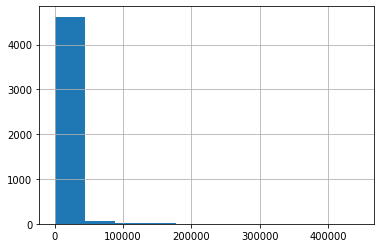

In [19]:
lens = train.processed_text.str.len()
print(lens.mean(), lens.std(), lens.max())
lens.hist()

In [ ]:

# embed_size = 300 # how big is each word vector
# max_features = 50000 # how many unique words to use (i.e num rows in embedding vector)
# maxlen = 27000 # max number of words in a question to use


# ## Tokenize the sentences
# tokenizer = Tokenizer(num_words=max_features)
# tokenizer.fit_on_texts(list(train['processed_text']))
# train_X = tokenizer.texts_to_sequences(train['processed_text'])
# val_X = tokenizer.texts_to_sequences(train['processed_text'])
# test_X = tokenizer.texts_to_sequences(test['processed_text'])

# ## Pad the sentences 
# train_X = pad_sequences(train_X, maxlen=maxlen)
# val_X = pad_sequences(val_X, maxlen=maxlen)
# test_X = pad_sequences(test_X, maxlen=maxlen)

# ## Get the target values




In [ ]:
# Y_train = train['grade'].values
# Y_val = dev['grade'].values

In [ ]:
# # max_features = 50000
# # max_len = 30000
# def get_model_1():
#     model = Sequential()
#     model.add(Embedding(max_features, embed_size))
#     model.add(LSTM(128, dropout=0.4, recurrent_dropout=0.4, input_shape=[1, 300], return_sequences=True))
#     model.add(Dropout(0.5))
#     model.add(Dense(1, activation='relu'))
#     return model

# def compile_model(model):
#   model.compile(loss=tf.keras.losses.MeanSquaredError(name="loss_mse")
# , optimizer='rmsprop', metrics=tf.keras.losses.MeanSquaredError(name="mse"))

# print(get_model_1().summary())



In [ ]:

# model = get_model_1()
# compile_model(model)
# batch_size = 8
# epochs = 2


# early = EarlyStopping(monitor="val_loss_mse", mode="min", patience=5)


# callbacks_list = [early]

# with tf.device('/device:GPU:0'):
#   history = model.fit(train_X, Y_train, validation_data=(val_X, Y_val), batch_size=batch_size, epochs=epochs, callbacks=callbacks_list)

In [ ]:
# model.save("/content/drive/MyDrive/SII/v1-no-embeddings.h5")


In [ ]:
# def build_vocab(sentences, verbose =  True):
#     """
#     :param sentences: list of list of words
#     :return: dictionary of words and their count
#     """
#     vocab = {}
#     for sentence in tqdm(sentences, disable = (not verbose)):
#         for word in sentence:
#             try:
#                 vocab[word] += 1
#             except KeyError:
#                 vocab[word] = 1
#     return vocab

In [ ]:
# sentences = train["processed_text"].apply(lambda x: x.split()).values
# vocab = build_vocab(sentences)
# print({k: vocab[k] for k in list(vocab)[:5]})

100%|██████████| 4725/4725 [00:01<00:00, 2778.06it/s]

{'piercing-ul': 3, 'tatuajele': 2, '-': 30657, 'vanitati': 2, 'adolescentine?': 1}


In [13]:
from gensim.models import KeyedVectors

embeddings_index = KeyedVectors.load_word2vec_format('/content/drive/MyDrive/SII/SII-Challenge/model.bin', binary=True)

In [14]:
embeddings_index_2 = KeyedVectors.load_word2vec_format('/content/drive/MyDrive/SII/SII-Challenge/embedding2.bin', binary=True)

In [ ]:
import operator 

def check_coverage(vocab,embeddings_index):
    a = {}
    oov = {}
    k = 0
    i = 0
    for word in tqdm(vocab):
        try:
            a[word] = embeddings_index[word]
            k += vocab[word]
        except:

            oov[word] = vocab[word]
            i += vocab[word]
            pass

    print('Found embeddings for {:.2%} of vocab'.format(len(a) / len(vocab)))
    print('Found embeddings for  {:.2%} of all text'.format(k / (k + i)))
    sorted_x = sorted(oov.items(), key=operator.itemgetter(1))[::-1]

    return sorted_x

In [ ]:
oov = check_coverage(vocab,embeddings_index)

100%|██████████| 555040/555040 [00:01<00:00, 399433.81it/s]

Found embeddings for 36.03% of vocab
Found embeddings for  76.50% of all text


In [ ]:
embeddings_index.similar_by_word("comentariu")

[('veziadaugă', 0.751944363117218),
 ('votscrie', 0.7479938268661499),
 ('.sobru', 0.7449974417686462),
 ('momentanscrieti', 0.7340505123138428),
 ('filcu', 0.7320773601531982),
 ('vechilasă', 0.7216393351554871),
 ('0)hits', 0.7141861319541931),
 ('var3', 0.7130448818206787),
 ('startanterior12345678910următorend', 0.7109917402267456),
 ('0raspundeiulia', 0.7098747491836548)]

In [ ]:
# def get_coefs(word,*arr): 
#   return word, np.asarray(arr, dtype='float32')

# embeddings_index = dict(get_coefs(*o.split(" ")) for o in open('/content/drive/MyDrive/SII/model.txt') if len(o)>100)

In [15]:
max_features = 30000

tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(https://drive.google.com/drive/folders/1lbObbbycaIrnQ4gBJoqrhRd1j6F4SMe2?usp=sharinglist(train['processed_text']))


In [16]:
all_embs = np.stack(embeddings_index.vectors)

emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    try:
      embedding_vector = embeddings_index[word]
      if embedding_vector is not None: embedding_matrix[i] = embedding_vector
    except:
      pass

print(embed_size)

100


In [17]:

embed_size = 100 # how big is each word vector
# max_features = 0000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 18000 # max number of words in a question to use


## Tokenize the sentences
# tokenizer = Tokenizer(num_words=max_features)
# tokenizer.fit_on_texts(list(train['processed_text']))
train_X = tokenizer.texts_to_sequences(train['processed_text'])
val_X = tokenizer.texts_to_sequences(dev['processed_text'])
test_X = tokenizer.texts_to_sequences(test['processed_text'])

## Pad the sentences 
train_X = pad_sequences(train_X, maxlen=maxlen)
val_X = pad_sequences(val_X, maxlen=maxlen)
test_X = pad_sequences(test_X, maxlen=maxlen)

## Get the target values

In [18]:
Y_train = train['grade'].values
Y_val = dev['grade'].values

In [24]:
def get_model_1():
  model = Sequential()
  # model.add(Embedding(max_features, embed_size))
  model.add(Embedding(max_features, embed_size, weights=[embedding_matrix], trainable=False))
  model.add(LSTM(units = 128, dropout = 0.2, recurrent_dropout = 0.2,return_sequences=True))
  model.add(LSTM(units = 64, dropout = 0.2, recurrent_dropout = 0.2))
  model.add(Dropout(0.1))
  model.add(Dense(units = 1, activation = 'relu'))
  
  return model
    

def get_model_2():
  inp = Input(shape=(maxlen, ))
  #x = Embedding(max_features, embed_size)(inp)

  x = Embedding(max_features, embed_size, weights=[embedding_matrix], trainable = False)(inp)
  x = Bidirectional(LSTM(128, return_sequences=True))(x)
  x = GlobalMaxPooling1D()(x)
  x = Dropout(0.25)(x)
  x = Dense(50, activation="relu")(x)
  x = Dropout(0.25)(x)
  x = Dense(1, activation="relu")(x)
  model = Model(inp,x)
  return model

def compile_model(model):
  model.compile(loss=tf.keras.losses.MeanSquaredError(name="loss_mse")
, optimizer='adam', metrics=tf.keras.losses.MeanSquaredError(name="mse"))

print(get_model_2().summary())

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 18000)]           0         
_________________________________________________________________
embedding_10 (Embedding)     (None, 18000, 100)        3000000   
_________________________________________________________________
bidirectional_5 (Bidirection (None, 18000, 256)        234496    
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 256)               0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 50)                12850     
_________________________________________________________________
dropout_11 (Dropout)         (None, 50)                0   

In [ ]:
model2 = get_model_2()
compile_model(model2)
batch_size = 32
epochs = 12


early = EarlyStopping(monitor="val_loss_mse", mode="min", patience=5)


callbacks_list = [early]

with tf.device('/device:GPU:0'):
  history = model2.fit(train_X, Y_train, validation_data=(val_X, Y_val), batch_size=batch_size, epochs=epochs, callbacks=callbacks_list)

Epoch 1/12
148/148 [==============================] - 227s 2s/step - loss: 11.2566 - mse: 11.2565 - val_loss: 3.4621 - val_mse: 3.4721
Epoch 2/12
137/148 [==========================>...] - ETA: 16s - loss: 4.3492 - mse: 4.3492

In [38]:
y_test = model1.predict(test_X)

In [43]:
print(y_test.shape)
print(y_test[y_test < 6])

(500, 1)
[4.959097  5.990784  5.4131575 5.604431  5.1833606 5.3884454 5.1110215
 5.3337708 5.668056  5.7971764 5.604555  4.442726  5.7296524 5.2951627
 0.       ]


**Train**

In [44]:

test_copy = get_frame(TEST_DEV)
test_copy.head()
test_copy['grades'] = y_test
test_copy.iloc[433]
test_copy.to_json('/content/drive/MyDrive/SII/SII-Challenge/test_results3-embd.json')

In [45]:
trial = pd.read_json('/content/drive/MyDrive/SII/SII-Challenge/test_results3-embd.json')
trial.tail()

,index,filename,text,category,grades
495,3591,Morometi,Morometii \n-Personaje principale \n -Parin...,romana,6.347172
496,5389,Padurea Spanzuratilor - Comentariu,Padurea spanzuratilor de Liviu Rebreanu \nTema...,romana,7.315770
497,1496,Referat Marsul lui Radetzky,MARELE ZID CHINEZESC \n Constructie gi...,istorie,6.059397
498,911,Referat Ciresarii - Cavalerii florii de cires,A Z U G A Valea Prahovei a ...,romana,8.547588
499,5266,Constitutia,ISTORIA CONSTITUŢIONALĂ A ROMÂNIEI \nParcurger...,istorie,8.459164


**Results**

**Bert**